# Analysis of Harvey flooding

Estimation of water input to Galveston Bay due to Hurricane Harvey precipitation.

## Set up for analysis and read in data

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from matplotlib.dates import date2num
import numpy as np
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import os
from collections import OrderedDict
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
from scipy.optimize import curve_fit
import shapely


In [2]:
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['land'])
pc = cartopy.crs.PlateCarree()
merc = cartopy.crs.Mercator(central_longitude=-85.0)

plots = {'Water Level [m]': {'color': '0.1', 'marker': 'o', 's': 200, 'alpha': 1, 'linewidths': 2}, 
         'East [m/s]': {'color': 'w', 'marker': 'v', 's': 120, 'alpha': 1},
         'Salinity': {'color': 'w', 'marker': '*', 's': 280, 'alpha': 1}, 
         'Along [cm/s]': {'color': 'w', 'marker': '^', 's': 150, 'alpha': 1},
         'Rain [cm]': {'marker': 's', 's':200, 'alpha': 1},
         'Flow rate [m^3/s]': {'marker': '>', 's': 200, 'alpha': 1}}

b = 'drive_data/'
baseb = b + 'bathy/'
basesf = b + 'shapefiles/'
based = b + 'stations/'
baset = b + 'twdb/'

In [3]:
run buoy_info.py

In [4]:
# See `Gather data` notebook. This reads in data from many sources, recalculates so that all data is hourly by taking 
# hourly averages, and shifts water levels to all be mean high water to match the bathymetry.
df = pd.read_csv(based + 'data06to04-15min.csv', parse_dates=True, index_col=0)

dt = (df.index[1] - df.index[0]).total_seconds()  # time step in seconds

In [5]:
# read in bathymetry data, as calculated in notebook `Process bathymetry`
d = np.load(baseb + 'bathy_galv_clean.npz')  # all of Galveston Bay
bathy = d['bathy']; dx = d['dx']; dy = d['dy']; lon = d['lon']; lat = d['lat']
bathyw = np.load(baseb + 'bathy_galv_west.npz')['bathy']  # West Bay
bathym = np.load(baseb + 'bathy_galv_main.npz')['bathy']  # Rest of Galveston Bay
bathyo = np.load(baseb + 'bathy_every_fifth.npz')['bathy'][::-1,:][1:-1,1:-1]  # all
bathyo = np.ma.masked_where(bathyo>0, bathyo)

## Map of data used

Still need to:
* label Trinity Bay, West and East bays

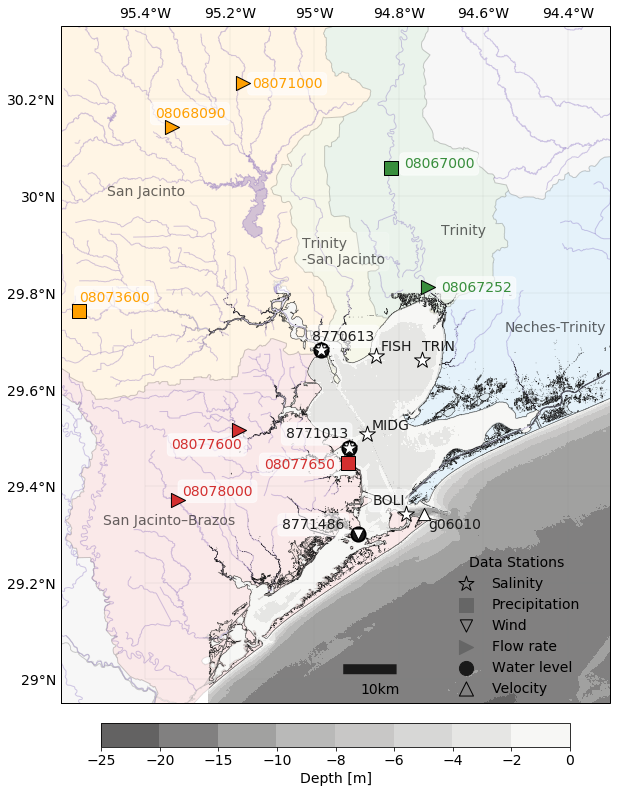

In [6]:

extent = [-95.6, -94.3, 28.95, 30.35]
x1, x2, y1, y2 = extent
pts = np.array([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])
ext = shapely.geometry.Polygon(pts)


fig = plt.figure(figsize=(14, 12))# (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent(extent, pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mpl.ticker.FixedLocator(np.arange(-95.4, -94, 0.2))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(29, 31, 0.2))
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False
mappable = ax.contourf(lon, lat, bathyo, [-25, -20, -15, -10, -8, -6, -4, -2, 0], vmin=-40, cmap=cmo.gray, transform=pc)
cb = fig.colorbar(mappable, orientation='horizontal', shrink=0.5, pad=0.025)
cb.set_label('Depth [m]')
ax.contour(lon, lat, bathyo.mask, 1, colors='0.1', linewidths=0.4, transform=pc)  # coastline


# Add river basins to plot
reader = cartopy.io.shapereader.Reader(basesf + 'Major_River_Basins_Shapefile/TWDB_MRBs_2014.shp')
basins = reader.records()
for basin in basins:
    if basin.attributes['basin_name'] == 'San Jacinto-Brazos':
        facecolor = buoys['OLDR']['color']  # 'red'
    elif basin.attributes['basin_name'] == 'San Jacinto':
        facecolor = buoys['TRIN']['color']  # 'orange'
    elif basin.attributes['basin_name'] == 'Trinity-San Jacinto':
        facecolor = buoys['8771013']['color']  # 'yellow'
    elif basin.attributes['basin_name'] == 'Trinity':
        facecolor = buoys['8771341']['color']  # 'green'
    elif basin.attributes['basin_name'] == 'Neches-Trinity':
        facecolor = buoys['8771972']['color']  # 'blue'
    else:
        facecolor = '0.7'
    ax.add_geometries([basin.geometry], pc, facecolor=facecolor, edgecolor='k', linewidth=1, alpha=0.1)

watercolor = buoys['8770808']['color']

# Add lakes to plot
reader = cartopy.io.shapereader.Reader(basesf + 'tceq_segments_2014_shp/TCEQ_SEGMENT_POLY_2014.shp')
lakes = reader.records()
for lake in lakes:
    if ext.contains(lake.geometry.centroid) and "Bay" not in lake.attributes['BASIN_NAME'] \
         and "Gulf" not in lake.attributes['BASIN_NAME']:
        ax.add_geometries([lake.geometry], pc, facecolor=watercolor, edgecolor=watercolor, alpha=0.25)

# Add rivers to plot
reader = cartopy.io.shapereader.Reader(basesf + 'tceq_segments_2014_shp/TCEQ_SEGMENT_LINE_2014.shp')
rivers = reader.records()
for river in rivers:
    if ext.contains(shapely.geometry.Point(river.geometry.bounds[0:2])) or ext.contains(shapely.geometry.Point(river.geometry.bounds[2:])):
        ax.add_geometries([river.geometry], pc, facecolor='none', edgecolor=watercolor, alpha=0.25)
        
props = dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.6)
        
# add buoys
for buoy in ['MIDG', 'BOLI', '8771013', '8771486', 'TRIN', '8770613', 'FISH', 'g06010']:
    try:
        lonsh, latsh = buoys[buoy]['llshift']
    except:
        lonsh, latsh = 0.01, 0.01
    if buoy == 'TRIN':
        lonsh += 0.02
    llsh = buoys[buoy]['ll'][0] + lonsh, buoys[buoy]['ll'][1] + latsh
    if buoy in ['g06010', 'MIDG', 'FISH', 'TRIN']:  # no box
        ax.text(llsh[0], llsh[1], buoy, transform=pc, fontsize=14, color='0.1')
    else:
        ax.text(llsh[0], llsh[1], buoy, transform=pc, fontsize=14, color='0.1', bbox=props)
    for var in buoys[buoy]['vars']:
        if var in plots:
            ax.scatter(*buoys[buoy]['ll'], **plots[var], transform=pc, label=var, edgecolors='k', zorder=5)

# Add precipitation stations
for buoy in ['08067000', '08073600', '08077650']:
    try:
        lonsh, latsh = buoys[buoy]['llshift']
    except:
        lonsh, latsh = 0.01, 0.01
    if buoy == '08073600':
        lonsh += 0.16
        latsh += 0.01
    elif buoy == '08077650':
        lonsh -= 0.03
    llsh = buoys[buoy]['ll'][0] + lonsh, buoys[buoy]['ll'][1] + latsh
    ax.text(llsh[0], llsh[1], buoy, transform=pc, fontsize=14, color=buoys[buoy]['color'], bbox=props)
    ax.scatter(*buoys[buoy]['ll'], color=buoys[buoy]['color'], **plots['Rain [cm]'], transform=pc, label=var, edgecolors='k', zorder=5)

# Add flow gauges
for buoy in ['08078000', '08077600', '08068090', '08071000', '08067252']:
    try:
        lonsh, latsh = buoys[buoy]['llshift']
    except:
        lonsh, latsh = 0.01, 0.01
    if buoy == '08077600':
        latsh -= 0.01
    llsh = buoys[buoy]['ll'][0] + lonsh, buoys[buoy]['ll'][1] + latsh
    ax.text(llsh[0], llsh[1], buoy, transform=pc, fontsize=14, color=buoys[buoy]['color'], bbox=props)
    ax.scatter(*buoys[buoy]['ll'], color=buoys[buoy]['color'], **plots['Flow rate [m^3/s]'], transform=pc, label=var, edgecolors='k', zorder=5)

# Add labels
ax.text(-95.49, 30.0, 'San Jacinto', transform=pc, alpha=0.6)
ax.text(-95.03, 29.86, 'Trinity\n-San Jacinto', transform=pc, alpha=0.6, bbox=dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.2))
ax.text(-95.5, 29.32, 'San Jacinto–Brazos', transform=pc, alpha=0.6)
ax.text(-94.7, 29.92, 'Trinity', transform=pc, alpha=0.6)
ax.text(-94.55, 29.72, 'Neches-Trinity', transform=pc, alpha=0.6);

# Distance key
llon, llat = -94.92, 29.02
eqproj = cartopy.crs.AzimuthalEquidistant(central_longitude=-95, central_latitude=30)
lx, ly = eqproj.transform_point(llon, llat, pc)  # convert to projection
ax.plot([lx, lx+10e3], [ly, ly], lw=10, transform=eqproj, color='0.1')
ax.text(llon+0.03, llat-0.05, '10km', transform=pc)

# Add legend
ax2 = fig.add_axes([0.65, 0.17, 0.13, 0.3], frameon=False)
ax2.scatter([], [], c='none', linewidths=1, s=250, marker='*', edgecolors='k', label='Salinity')
ax2.scatter([], [], c='0.4', s=200, marker='s', label='Precipitation')
ax2.scatter([], [], c='none', edgecolors='k', linewidths=1, s=150, marker='v', label='Wind')
ax2.scatter([], [], c='0.4', s=200, marker='>', label='Flow rate')
ax2.scatter([], [], c='0.1', s=200, marker='o', label='Water level')
ax2.scatter([], [], c='none', edgecolors='k', linewidths=1, s=200, marker='^', label='Velocity', alpha=1)

ax2.legend(scatterpoints=1, frameon=False, title='Data Stations', loc='lower right')
ax2.set_axis_off()

fig.savefig('figures/map_full.png', bbox_inches='tight', dpi=300)
fig.savefig('figures/map_full_lowres.png', bbox_inches='tight')


## Summary of conditions

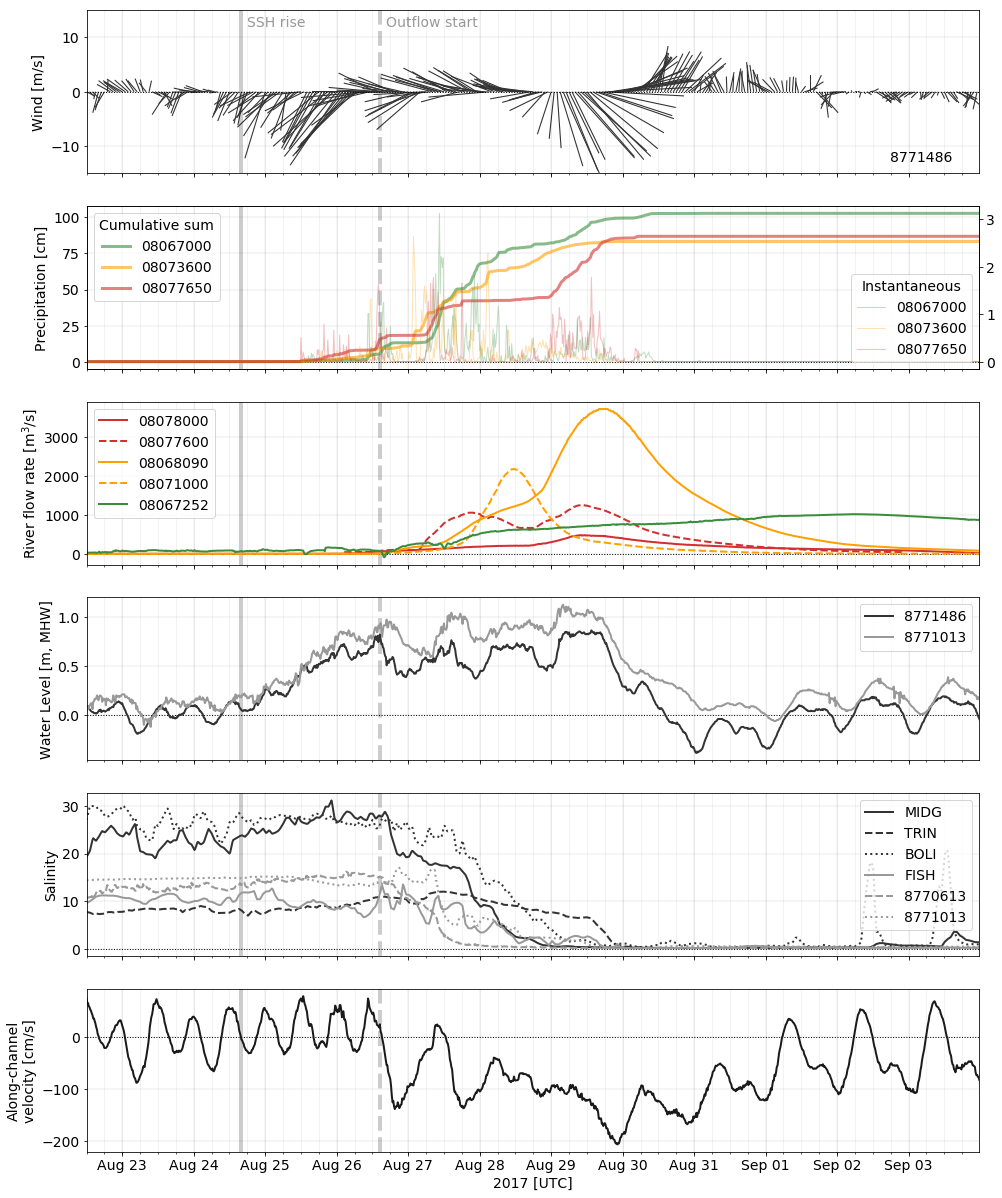

In [6]:
# define short dataframe to simplify plotting
# dsp = '2017-08-26 00:00'; dep = '2017-08-27'
dsp = '2017-08-22 12:00'; dep = '2017-09-3'
ddt = 1
dfsh = df.copy()[::ddt][dsp:dep]
dfsh['idx'] = date2num(pd.to_datetime(dfsh.index).to_pydatetime())
width = 0.2

date_ssh = pd.Timestamp('2017-8-24 16:00')  # when sea surface starts to raise
date_outflow = pd.Timestamp('2017-8-26 14:30')  # when salinity starts to drop, based on velocity

fig, axes = plt.subplots(6, 1, figsize=(16,21), sharex=True)

    
## Wind ##
buoy = '8771486'
dw = 4
axes[0].quiver(dfsh['idx'][::dw], np.zeros(len(dfsh[::dw])), dfsh[buoy + ': East [m/s]'][::dw], dfsh[buoy + ': North [m/s]'][::dw], 
               headaxislength=0, headlength=0, width=width, units='y', scale_units='y', scale=1, 
               color='0.2', label=buoy)
axes[0].text(0.9, 0.075, buoy, fontsize=14, transform=axes[0].transAxes)
    
    
## Precipitation ##
ax1 = axes[1].twinx()
bs = ['08067000', '08073600', '08077650']
for i, buoy in enumerate(bs):
    ax1.plot(dfsh.index, dfsh[buoy + ': Rain [cm]'], color=buoys[buoy]['color'], lw=1, alpha=0.3)
    axes[1].plot(dfsh.index, dfsh[buoy + ': Rain [cm]'].cumsum(), color=buoys[buoy]['color'], lw=3, alpha=0.6)
axes[1].legend(bs, loc='upper left', title='Cumulative sum')
ax1.legend(bs, loc='lower right', title='Instantaneous')


## River Gauges ##
bs = ['08078000', '08077600', '08068090', '08071000', '08067252']
linestyles = ['-', '--', '-', '--', '-']
for buoy, ls in zip(bs, linestyles):
    axes[2].plot(dfsh.index, dfsh[buoy + ': Flow rate [m^3/s]'], color=buoys[buoy]['color'], lw=2, ls=ls)
axes[2].legend(bs, loc='upper left')


## Sea Level ##
for buoy, col in zip(['8771486', '8771013'], ['0.2', '0.6']):
    axes[3].plot(dfsh.index, dfsh[buoy + ': Water Level [m, MHW]'], label=buoy, color=col, lw=2)
axes[3].legend()
    
    
## Salinity ##
bs = ['MIDG', 'TRIN', 'BOLI', 'FISH', '8770613', '8771013']
linestyles = ['-', '--', ':', '-', '--', ':']
colors = ['0.2', '0.2', '0.2', '0.6', '0.6', '0.6']
for buoy, ls, col in zip(bs, linestyles, colors):
    axes[4].plot(dfsh.index, dfsh[buoy + ': Salinity'], label=buoy, color=col, lw=2, ls=ls)
axes[4].legend(loc='best')


## Entrance along-channel velocity ##
axes[5].plot(dfsh.index, dfsh['smean'], color='0.1', lw=2)


axes[0].set_ylim(-15,15)
axes[0].set_xlim(dfsh.index[0], dfsh.index[-1])
for ax in axes:
    ax.hlines(0, dfsh.index[0], dfsh.index[-1], linewidth=1, linestyle=':')
    ax.grid(which='major', lw=1.5, color='k', alpha=0.05)
    ax.grid(which='minor', lw=1, color='k', alpha=0.05)
    # overlay lines for events
    ylims = ax.get_ylim()
    ax.set_ylim(*ylims)
    ax.vlines(date_ssh, *ylims, linewidth=4, alpha=0.2, color='k')
    ax.vlines(date_outflow, *ylims, linewidth=4, alpha=0.2, color='k', linestyle='--')

# labels
axes[0].set_ylabel('Wind [m/s]')
axes[1].set_ylabel('Precipitation [cm]')
axes[2].set_ylabel('River flow rate [m$^3$/s]')
axes[3].set_ylabel('Water Level [m, MHW]')
axes[4].set_ylabel('Salinity')
axes[5].set_ylabel('Along-channel\nvelocity [cm/s]')

# label dates
axes[0].text(0.18, 0.9, 'SSH rise', transform=axes[0].transAxes, alpha=0.4)
axes[0].text(0.335, 0.9, 'Outflow start', transform=axes[0].transAxes, alpha=0.4)


minor = mpl.dates.HourLocator(byhour=np.arange(0,24,6))
ax.xaxis.set_minor_locator(minor)
major = mpl.dates.HourLocator(byhour=np.arange(0,24,24))
ax.xaxis.set_major_locator(major)
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))

handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
# ax.legend(by_label.values(), by_label.keys(), loc='upper right')   

ax.set_xlabel('2017 [UTC]')

plt.savefig('figures/conditions.pdf', bbox_inches='tight')

## Flushing timescales

In [7]:
times = {'FISH': {'start': '2017-8-26 22:30', 'stop': '2017-8-30 12:00'},
        'MIDG': {'start': '2017-8-26 16:30', 'stop': '2017-8-29 00:00'},
        'TRIN': {'start': '2017-8-27 12:00', 'stop': '2017-8-31 00:00'},
        'BOLI': {'start': '2017-8-27 12:00', 'stop': '2017-8-30 00:00'},
        '8770613': {'start': '2017-8-26 15:30', 'stop': '2017-8-29 00:00'},
        '8771013': {'start': '2017-8-27 09:00', 'stop': '2017-8-29 20:00'}}

# allowing for multiple starts and stops of salinity events:
# times = {'FISH': {'starts': ['2017-8-26 22:00'], 'stops': ['2017-8-30 12:00']},
#         'MIDG': {'starts': ['2017-8-26 16:00'], 'stops': ['2017-8-29 00:00']},
#         'TRIN': {'starts': ['2017-8-27 12:00','2017-8-27 12:00', '2017-8-29 12:00'], 'stops': ['2017-9-1 00:00', '2017-8-29 12:00', '2017-9-1 00:00']},
#         'BOLI': {'starts': ['2017-8-27 16:00'], 'stops': ['2017-8-30 00:00']},
#         '8770613': {'starts': ['2017-8-26 16:00', '2017-8-26 16:00','2017-8-27 08:00'], 'stops': ['2017-8-29 00:00','2017-8-27 08:00','2017-8-29 00:00']},
#         '8771013': {'starts': ['2017-8-27 08:00'], 'stops': ['2017-8-29 20:00']}}

saltcols = [col for col in df.columns if 'Salinity' in col]
saltcols = [col for col in saltcols if not 'OLDR' in col]
saltcols = [col for col in saltcols if not 'B:' in col]
saltcols

# get some datetime numbers to use in calculation
df['idx'] = date2num(df.index.to_pydatetime())

In [8]:
# calculate lag times, which only depend on start time I chose vs. outflow start time
# Start time scale dictionary, tau
tau = dict()

for key in times.keys():
    tau[key] = dict()
    tau[key]['lag'] = (pd.Timestamp(times[key]['start']) - date_outflow).total_seconds()/86400

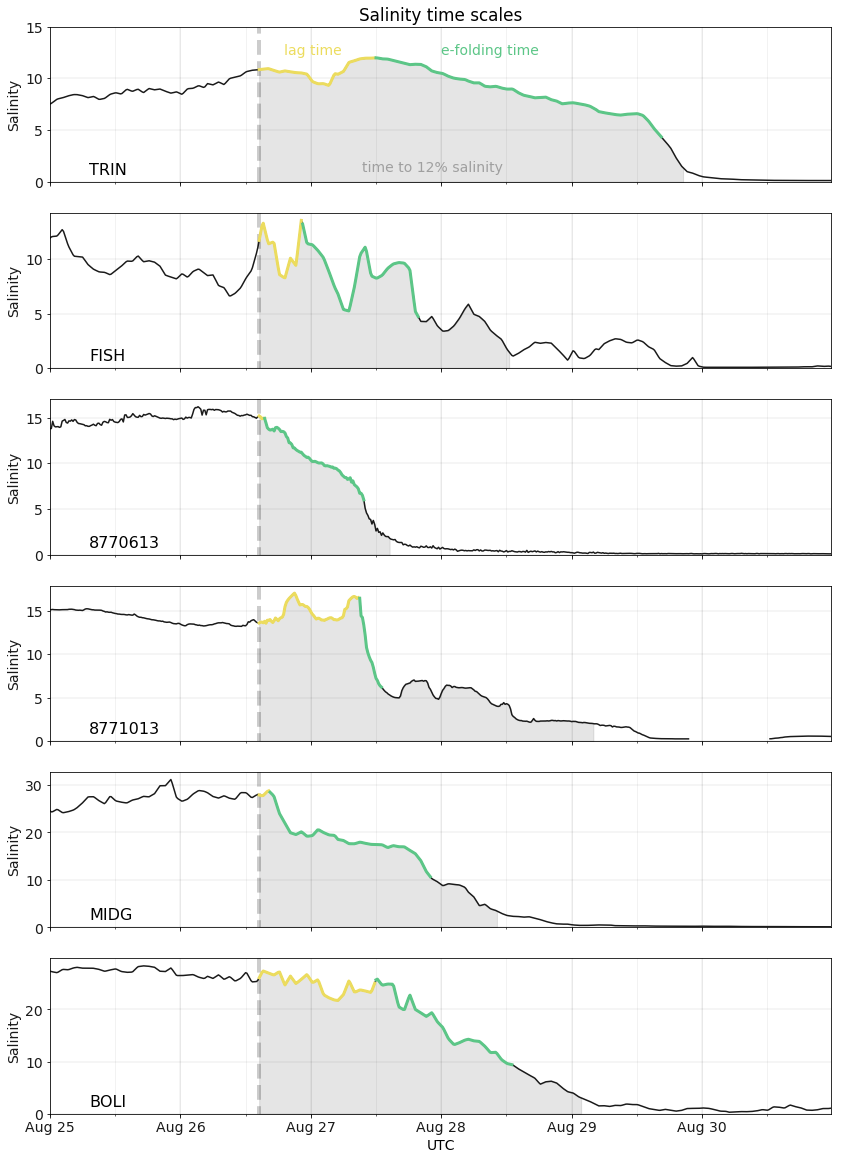

In [57]:
cols = ['TRIN: Salinity', 'FISH: Salinity', '8770613: Salinity', '8771013: Salinity', 'MIDG: Salinity', 'BOLI: Salinity']

colorlag = '#ECDC5E'
colorefold = '#5CC687'
color12 = '#144997'

dst = '2017-8-25'; den = '2017-8-30'
fig, axes = plt.subplots(len(saltcols), 1, figsize=(14,20), sharex=True)

taus = np.empty(len(saltcols))
for j, (col, ax) in enumerate(zip(cols, axes)):

    # get fit in linear space
    name = col.split(':')[0]

    
    start = times[name]['start']
    stop = times[name]['stop']

    tnums = df['idx'][start:stop] - df['idx'][start]  # decimal days
    dfshort = df[col][start:stop]
    
    S0 = df[col][start]  # initial salinity before freshwater inflow
    time37 = dfshort.index[np.where(dfshort<=S0*(1/np.e))[0][0]]  # time at 37%*S0 salinity, datetime when efolding time happens
    tau[name]['efold'] = (time37 - pd.Timestamp(start)).total_seconds()/86400  # save e folding tau, in units of days

    time12 = dfshort.index[np.where(dfshort<=S0*(1/(3*np.e)))[0][0]]
    tau[name]['timeto12'] = tau[name]['lag'] + (time12 - pd.Timestamp(start)).total_seconds()/86400  # save lag + flooding time to 12% S0, in days

    # plot
    color = '0.1'
    ax.plot(df[dst:den].index, df[col][dst:den], color=color)  # plot data
    ax.tick_params(labelcolor=color)
    ax.set_ylabel('Salinity', color=color)
    # overlay lag time
    tstrlag = date_outflow + pd.Timedelta(str(tau[name]['lag']) + 'days')
    ax.plot(df[date_outflow:tstrlag].index, df[col][date_outflow:tstrlag], color=colorlag, lw=3)  # plot data
    # overlay efolding time
    tstrefold = pd.Timestamp(start) + pd.Timedelta(str(tau[name]['efold']) + 'days')
    ax.plot(df[start:tstrefold].index, df[col][start:tstrefold], color=colorefold, lw=3)  # plot data
#     # overlay time to 12%
#     tstr12 = date_outflow + pd.Timedelta(str(tau[name]['timeto12']) + 'days')
#     ax.plot(df[tstrefold:tstr12].index, df[col][tstrefold:tstr12], color=color12, lw=3)  # plot data
    
    tstr12 = date_outflow + pd.Timedelta(str(tau[name]['timeto12']) + 'days')
    ax.fill_between(df[date_outflow:tstr12].index, 0, df[col][date_outflow:tstr12], color='k', alpha=0.1)
    
    # write station name and tau
    ax.text(0.05, 0.25 - 2*0.1, name, transform=ax.transAxes, fontsize=16)
    
    hours = mpl.dates.HourLocator(byhour=np.arange(0,24,12))
    ax.xaxis.set_minor_locator(hours)
    days = mpl.dates.HourLocator(byhour=np.arange(0,24,24))
    ax.xaxis.set_major_locator(days)

    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))
    ax.grid(which='major', lw=1.5, color='k', alpha=0.05)
    ax.grid(which='minor', lw=1, color='k', alpha=0.05)
    
    # label outflow start
    ylims = ax.get_ylim()
    ax.set_ylim(0, ylims[1])
    if j == 0:  # first subplot, leaving space for line labels
        ax.set_ylim(0, 15)
        ylims = 0, 15
        # label lines
        ax.text(0.3, 0.82, 'lag time', transform=ax.transAxes, color=colorlag)
        ax.text(0.5, 0.82, 'e-folding time', transform=ax.transAxes, color=colorefold)
        ax.text(0.4, 0.07, 'time to 12% salinity', transform=ax.transAxes, color='k', alpha=0.3)
    ax.vlines(date_outflow, *ylims, linewidth=4, alpha=0.2, color='k', linestyle='--')

axes[0].set_title('Salinity time scales')
axes[-1].set_xlabel('UTC')
axes[-1].autoscale(enable=True, axis='x', tight=True)


fig.savefig('figures/times_flushing.pdf', bbox_inches='tight')

### Present flushing timescale $\tau_f$ itself

In [40]:
shift = {'TRIN': (0.01,0.01), 'FISH': (0.01,0.01), '8770613': (-0.03,0.02), 'MIDG': (0.01,0.01),
      '8771013': (-0.06,0.02), 'BOLI': (0.0,0.02)}

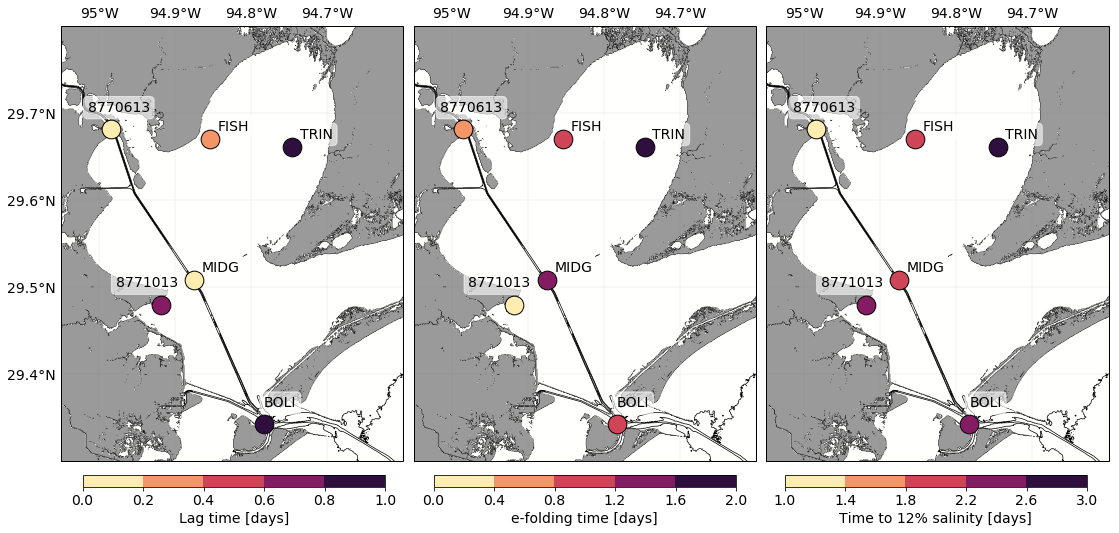

In [56]:
props = dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.6)
marker = 'o'
zorder = 10
s = 350
cmap = cmo.matter

types = ['lag', 'efold', 'timeto12']
typenames = ['Lag time', 'e-folding time', 'Time to 12% salinity']

fig = plt.figure(figsize=(15, 8))
fig.subplots_adjust(wspace=0.03, left=0.01, right=0.98)

for i, (which, whichname) in enumerate(zip(types, typenames)):
    ax = fig.add_subplot(1,3,i+1, projection=merc)
    ax.set_extent([-95.05, -94.6, 29.3, 29.8], pc)
    gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mpl.ticker.FixedLocator(np.arange(-96.2, -93.0, 0.1))
    gl.ylocator = mpl.ticker.FixedLocator(np.arange(28.6, 31, 0.1))
    gl.xlabels_bottom = False  # turn off labels where you don't want them
    gl.ylabels_right = False
    if i in [1,2]:
        gl.ylabels_left = False

    # bathymetry contours
    ax.contour(lon, lat, bathyo, [-20,-15,-10], colors='k', linewidths=0.7, transform=pc, linestyles='-')  # some values

    # add bay-area detailed coastline
    ax.contour(lon, lat, bathyo.mask, 1, colors='0.1', linewidths=0.4, transform=pc)  # coastline

    # color land
    ax.pcolormesh(lon, lat, bathyo.mask, cmap=cmo.gray_r, vmin=0, vmax=3, transform=pc)

    # range of data
    data = np.asarray([tau[key][which] for key in tau.keys()])
    vmin = data.min(); vmax = data.max()
#     print(vmin, vmax)
    
    
    # define the bins and normalize
    bounds = np.linspace(np.round(vmin), np.round(vmax), 6)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


    for saltcol in saltcols:
        buoy = saltcol.split(':')[0]
        sdx, sdy = shift[buoy]

        # plot data
        lonsta, latsta = buoys[buoy]['ll']
        param = tau[buoy][which]
        mappable = ax.scatter(lonsta, latsta, c=param, s=s, transform=pc, zorder=zorder, norm=norm, 
                              vmin=vmin, vmax=vmax, cmap=cmap, edgecolors='k', marker=marker)
        ax.text(lonsta+sdx, latsta+sdy, buoy, transform=pc, bbox=props)    
    
    
    # colorbar by hand
    ax2 = fig.add_axes([0.03+i*.325, 0.08, 0.28, 0.02])
    cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                    norm=norm,
                                    # to use 'extend', you must
                                    # specify two extra boundaries:
                                    boundaries=bounds,
                                    ticks=bounds,  # optional
                                    spacing='proportional', orientation='horizontal')
    cb2.set_label(whichname + ' [days]')
fig.savefig('figures/timescales_flushing_low.png', bbox_inches='tight')
fig.savefig('figures/timescales_flushing.png', bbox_inches='tight', dpi=300)

Things to possibly add:
* when flushing started
* mention that individual events at each station can be faster or slower than overall timescale
* give results for timescales and delta times and absolute datetime for % salinity reduction
* reference Rayson paper
* time from set date to 2 psu or similar

### Notes:

* May be other, more relevant ways to present flushing timing
* the overall timescales have the benefit of trying to summarize timing over flushing but in cases where there were really two smaller events, the overall timescale doesn't capture it well (TRIN especially)
 * could use individual events, but at what point am I just saying that the flushing took X amount of time?
 * what is useful?

Table showing timing with results:

In [16]:
for saltcol, tau in zip(saltcols, taus):
    name = saltcol.split(':')[0]
    print('%s start date/time: %s, tau: %s' % (saltcol, times[name]['starts'][0], tau))

FISH: Salinity start date/time: 2017-8-26 22:00, tau: 1.53937222895
MIDG: Salinity start date/time: 2017-8-26 16:00, tau: 1.16440876775
TRIN: Salinity start date/time: 2017-8-27 12:00, tau: 0.583337109678
BOLI: Salinity start date/time: 2017-8-27 16:00, tau: 1.18839074442
8770613: Salinity start date/time: 2017-8-26 16:00, tau: 0.968533026334
8771013: Salinity start date/time: 2017-8-27 08:00, tau: 0.803616101049


# 1. Calculate channel flux from Galveston Bay

We calculate the flux through Galveston channel, $Q_{ch}$, in two ways — one directly from data and one through conservation of salinity in the bay. The first should be good over time, regardless of the salinity state, but has large error because the data is at a single $x,y,z$ location and is assumed to be uniform across the whole channel. The second is only valid when there is salinity in the bay which is not true during the major flooding event. However, we use it to reduce the error in the first method.

We assume that any outflow from the West and East bays is insignificant.

## 1a. From current meter in channel

$\begin{align}
Q_{ch} &= \iint_A U_{ch}(t) \, dA  \\
~ &\approx U_{ch} \cdot A
\end{align}$

where the integral of the along-channel velocity, $U_{ch}$, of a cross-section of Galveston channel is approximated by the previously-calculated vertical mean of the along-channel velocity at buoy `g06010` times the approximate cross-sectional area, width $W$ times depth $D$. Instead of estimating the cross-sectional area of the channel, we leave this constant as a parameter to be estimated by comparing with the salinity conservation method. This parameter will include errors in the method too.

In [42]:
# negative sign because original orientation is positive into the bay
Uch = -df['smean']/100.  # m/s

## 1b. From salinity conservation

Conservation of salinity in Galveston Bay gives:

$
\begin{align}
\partial (S V)/\partial t &= S_{in}Q_{in} - S_{ch} Q_{ch} \\
\partial (S V)/\partial t &= - S_{ch} Q_{ch} \\
\Rightarrow Q_{ch} &= -\frac{1}{S_{ch}} \frac{\partial (S V)}{\partial t}
\end{align}
$

where the input salinity, $S_{in}$, is assumed to be fresh so $S_{in}=0$ and $S_{ch}$ is the channel salinity.

We have data from TWDB station BOLI to represent $S_{ch}$. Rayson et al 2017 finds that the volume-averaged salinity in the bay is reasonably represented by three TWDB stations: $S(t) = \frac{1}{3} TRIN + \frac{1}{3} MIDG + \frac{1}{3} BOLI$; we use this result.

The derivative term is calculated as follows, where the volume is approximated as the surface area times the average depth plus a representative sea surface height:

$
\begin{align}
    \frac{\partial (S V)}{\partial t} &= A \frac{\partial [S(H+\eta)]} {\partial t}.
\end{align}
$

We calculate this term for both of the bays (main and east).

Surface area of the bay is calculated using bathymetry of Galveston Bay as calculated in `Process bathymetry` notebook.

In [43]:
# Main bay surface area
Am = np.nansum(~np.isnan(bathym)*dx*dy)

# Full Galveston Bay
Afull = np.nansum(~np.isnan(bathy)*dx*dy)

# West Bay
Aw = np.nansum(~np.isnan(bathyw)*dx*dy)

# Average depth for main bays
Hm = -np.nanmean(bathym)

# Average depth for full galv bay
Hfull = -np.nanmean(bathy)
# Average depth for west bay
Hw = -np.nanmean(bathyw)


In [45]:
S = (0.33*df['MIDG: Salinity'] + 0.33*df['BOLI: Salinity'] + 0.33*df['TRIN: Salinity'])#.rolling(window=12, center=True).mean()
Sch = df['BOLI: Salinity']

eta = df['8771013: Water Level [m, MHW]']  # m, for main bay
etaw = df['8771486: Water Level [m, MHW]']  # m, for dealing with west bay separately

# Full Galveston Bay, west bay salinity as MIDG (same as main bay)
SV = Am*S*(eta+Hm) + Aw*S*(etaw+Hw)
dSVdt = SV.diff()/dt  # divide by time step for data frequency


We can then calculate the channel flux as follows from salinity conservation (which applies before and after the storm):

In [46]:
# full galv bay
Qch1b = dSVdt/-Sch

## Combining methods to get best $Q_{ch}$

Salinity conservation (method 1b) gives us a more robust calculation for the channel flux, but it isn't meaningful after the whole bay is fresh. Thus, we combine this with applying current data uniformly across the channel (method 1a) to get an improved estimate.

We seek a fixed constant for each of flood and ebb to improve the comparison of $U_{ch}$ with Qch1b. So, we use a linear fit between the two functions over the time period before Hurricane Harvey, from August 1 through August 23rd, with a two hour rolling mean to smooth.

$Q_{ch} = \alpha u = (H + \eta) L u = (\alpha + \beta \eta) u$

$ Q_{ch} / u = \alpha + \beta \eta $, where $\eta$ is time-varying.

In [54]:
def line(t, alpha, beta):
    return alpha + beta*t

(array([ 55212.29028482, -69136.42660933]), array([[  2.72439232e+06,  -1.48357617e+07],
       [ -1.48357617e+07,   1.33338428e+08]]))
(array([ 38302.835604  , -17779.77464716]), array([[  1668635.58228788,   4455491.16617257],
       [  4455491.16617257,  35164843.68207824]]))


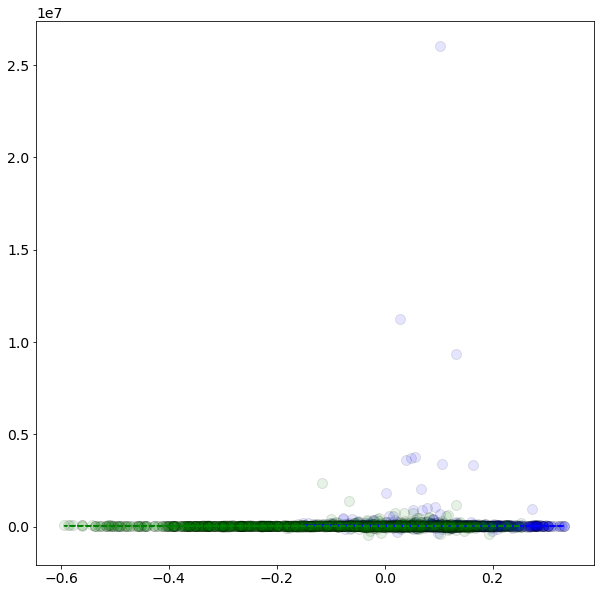

In [106]:
dst1 = '2017-8-1'; det1 = '2017-8-24'

etascale = df['8771341: Water Level [m]'] 

# try splitting into ebb and flood for fit
ind = (~Uch[dst1:det1].isnull()) & (~Qch1b[dst1:det1].isnull()).values
indf = ind[Uch[dst1:det1] < 0]  # into the bay, flood tide, since switched sign already
inde = ind[Uch[dst1:det1] >= 0]  # out of the bay, ebb tide
Uf = Uch[dst1:det1][Uch[dst1:det1] < 0].copy()
etaf = etascale[dst1:det1][Uch[dst1:det1] < 0].copy()
Qf = Qch1b[dst1:det1][Uch[dst1:det1] < 0].rolling(window=8, center=True).mean().copy()
Ue = Uch[dst1:det1][Uch[dst1:det1] >= 0].copy()
etae = etascale[dst1:det1][Uch[dst1:det1] >= 0].copy()
Qe = Qch1b[dst1:det1][Uch[dst1:det1] >= 0].rolling(window=8, center=True).mean().copy()


fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(etaf, Qf/Uf, s=100, c="b", edgecolor='k', alpha=0.1)
ax.scatter(etae, Qe/Ue, s=100, c="g", edgecolor='k', alpha=0.1)


# only use non-nans between the two time series
locs = ~(Qf/Uf).isnull() & ~etaf.isnull() & (Sch[dst1:det1][Uch[dst1:det1] < 0] > 5) & (Uf[dst1:det1][Uch[dst1:det1] < 0] < -0.05)
fitf = curve_fit(line, etaf[locs], (Qf/Uf)[locs])
data_fit = line(etaf, *fitf[0])
print(fitf)
ax.plot(etaf, data_fit, '--b')  # plot fit

locs = ~(Qe/Ue).isnull() & ~etae.isnull() & (Sch[dst1:det1][Uch[dst1:det1] >= 0] > 5) & (Ue[dst1:det1][Uch[dst1:det1] >= 0] > 0.05)
fite = curve_fit(line, etae[locs], (Qe/Ue)[locs])
data_fit = line(etae, *fite[0])
print(fite)
ax.plot(etae, data_fit, '--g')  # plot fit

# ax.set_ylim(-1e5, 1e5)

# Qcht = Uch.copy()
# Qcht[Uch < 0] = Uch[Uch < 0]*fitf[0]
# Qcht[Uch >= 0] = Uch[Uch >= 0]*fite[0]

# ax.set_xlabel('Along-channel speed [m/s]')
# ax.set_ylabel('Channel flux from salinity conservation [m$^3$/s]')

# ax.text(0.4, 0.2, 'Ebb tide scaling coefficient: %5d' % fite[0][0], transform=ax.transAxes, color='g', fontsize=16)
# ax.text(0.4, 0.15, 'Flood tide scaling coefficient: %5d' % fitf[0][0], transform=ax.transAxes, color='b', fontsize=16)

# # this is now the improved flux calculation which applies during the storm too

# Qch = Qcht.copy()

# fig.savefig('figures/scaling.png', bbox_inches='tight', dpi=200)

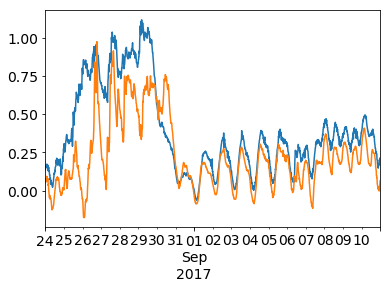

In [113]:
df['8771013: Water Level [m]']['2017-8-24':'2017-9-10'].plot()
df['8770971: Water Level [m]']['2017-8-24':'2017-9-10'].plot()

In [107]:
da = np.argmax((Qf/Uf))
da

Timestamp('2017-08-22 20:15:00')

In [108]:
Qf[da], Uf[da]

(-6424.3257839088365, -0.00024672265945533013)

In [83]:
curve_fit?

In [35]:
def fixed_line(t, slope):
    return slope*t

(array([ 47914.46990828]), array([[ 357788.96768811]]))
(array([ 39882.22087671]), array([[ 209398.36965904]]))


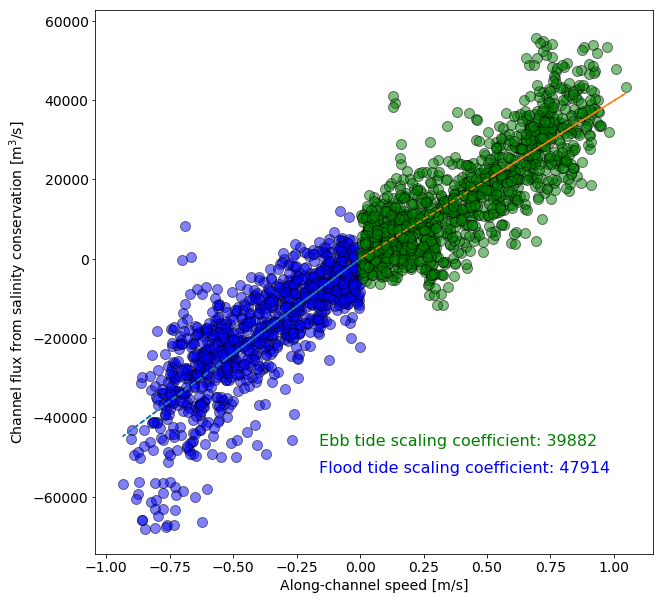

In [36]:
dst1 = '2017-8-1'; det1 = '2017-8-24'

# try splitting into ebb and flood for fit
ind = (~Uch[dst1:det1].isnull()) & (~Qch1b[dst1:det1].isnull()).values
indf = ind[Uch[dst1:det1] < 0]  # into the bay, flood tide, since switched sign already
inde = ind[Uch[dst1:det1] >= 0]  # out of the bay, ebb tide
Uf = Uch[dst1:det1][Uch[dst1:det1] < 0].copy()
Qf = Qch1b[dst1:det1][Uch[dst1:det1] < 0].rolling(window=8, center=True).mean().copy()
Ue = Uch[dst1:det1][Uch[dst1:det1] >= 0].copy()
Qe = Qch1b[dst1:det1][Uch[dst1:det1] >= 0].rolling(window=8, center=True).mean().copy()


fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(Uf, Qf, s=100, c="b", edgecolor='k', alpha=0.5)
ax.scatter(Ue, Qe, s=100, c="g", edgecolor='k', alpha=0.5)


# only use non-nans between the two time series
locs = ~Uf.isnull() & ~Qf.isnull() & (Sch[dst1:det1][Uch[dst1:det1] < 0] > 5)
fitf = curve_fit(fixed_line, Uf[locs], Qf[locs])
data_fit = fixed_line(Uf, *fitf[0])
print(fitf)
ax.plot(Uf, data_fit, '--')  # plot fit

locs = ~Ue.isnull() & ~Qe.isnull() & (Sch[dst1:det1][Uch[dst1:det1] >= 0] > 5)
fite = curve_fit(fixed_line, Ue[locs], Qe[locs])
data_fit = fixed_line(Ue, *fite[0])
print(fite)
ax.plot(Ue, data_fit, '--')  # plot fit

Qcht = Uch.copy()
Qcht[Uch < 0] = Uch[Uch < 0]*fitf[0]
Qcht[Uch >= 0] = Uch[Uch >= 0]*fite[0]

ax.set_xlabel('Along-channel speed [m/s]')
ax.set_ylabel('Channel flux from salinity conservation [m$^3$/s]')

ax.text(0.4, 0.2, 'Ebb tide scaling coefficient: %5d' % fite[0][0], transform=ax.transAxes, color='g', fontsize=16)
ax.text(0.4, 0.15, 'Flood tide scaling coefficient: %5d' % fitf[0][0], transform=ax.transAxes, color='b', fontsize=16)

# this is now the improved flux calculation which applies during the storm too

Qch = Qcht.copy()

fig.savefig('figures/scaling.png', bbox_inches='tight', dpi=200)

The improved channel flux is the the data-based method (1a) times the slope of the fit between the two methods. The constant factors (fitf[0] and fite[0]) represent the cross-sectional area of the channel at the location of the current meter times an error factor accounting for the fact that the channel flow is not uniform across the channel, and that this could be different on ebb and flood tides.

Note that since the fitf[0] and fite[0] accounts for both channel area and an error factor, its units are m$^2$.

With this adjustment, the two approaches align well before the storm, as seen in the figure below. The salinity conservation approach (method 1b) does not give reasonable results once the bay is too fresh (around August 28th).

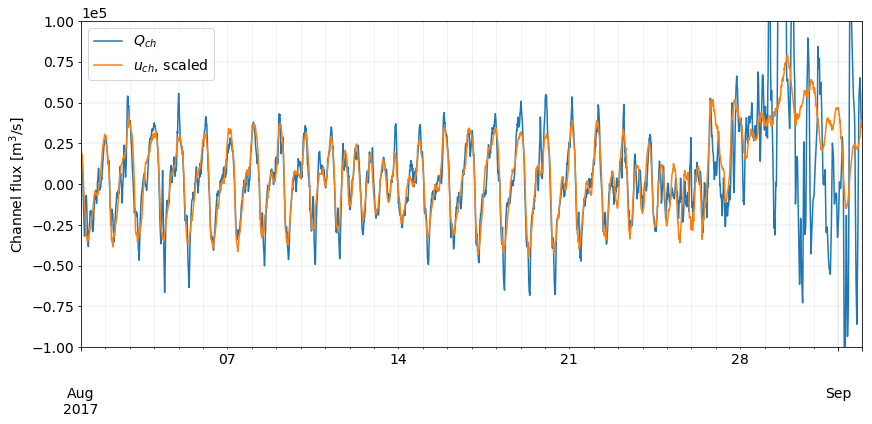

In [37]:
dst2 = '2017-8-1'; det2 = '2017-9-1'

fig, ax = plt.subplots(1, 1, figsize=(14,6), sharex=True, sharey=True)

# Qch1b[dst2:det2].plot(ax=ax, label='$Q^s_{ch}$')
Qch1b[dst2:det2].rolling(window=8, center=True).mean().plot(ax=ax, label='$Q_{ch}$')
Qch[dst2:det2].plot(label='$u_{ch}$, scaled', ax=ax)
ax.grid(which='major', lw=1.5, color='k', alpha=0.05)
ax.grid(which='minor', lw=1, color='k', alpha=0.05)
    
ax.legend()
ax.set_ylabel('Channel flux [m$^3$/s]')
ax.set_ylim(-1e5, 1e5)
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
fig.savefig('figures/channel_flux_comparison.pdf', bbox_inches='tight')

This number is the equivalent area of the channel cross-section — it is the area times a factor to account for errors in assuming a constant along-channel velocity across the channel and with depth.

The cross-sectional area is approximately:

In [38]:
W = 2500  # meters, calculated with length tool in google earth

D = (250*22 + 325*34 + 1050*45 + 425*35 + 50*24 + 100*17 + 300*1)/2500  # feet
D /= 3.28084  # meters
W*D  # m^2

24955.499201424027

meaning that the equivalent area on flood and ebb is:

In [39]:
print(fitf[0]/(W*D), fite[0]/(W*D))

[ 1.91999645] [ 1.59813356]


times the area of the channel there and therefore is in the right ballpark.

# 2. Calculate inflow to Galveston Bay

For this we use a control volume of Galveston Bay with the previously-calculated function for $Q_{ch}$

$\begin{align}
\partial V/\partial t &= Q_{in} - Q_{ch} ~~~~~~~~(1) \\
\Rightarrow Q_{in}(t) &= Q_{ch}(t) + \partial V/\partial t
\end{align}$

where $V(t)$ is the volume of Galveston Bay, $Q_{in}(t)$ is the water input to Galveston Bay, and $Q_{ch}(t)$ is the flux in Galveston Bay channel.

## 2a. Calculate volume of bay in time

Assuming that any change in x/y area of the bay due to flooding is limited, we have the following:

$\begin{align}
\partial V/\partial t &= \partial /\partial t \left(\iiint dxdydz\right) \\
~ &= \partial /\partial t \left(\iint \int_{z=h}^{0} dzdxdy + \iint \int_{z=0}^{\eta} dzdxdy\right) \\
~ &= \partial /\partial t \left(\iint \int_{z=h}^{0} dzdxdy\right) + \partial /\partial t \left(\iint\int_{z=0}^{\eta} dzdxdy\right) \\
~ &= \partial /\partial t \left(\iint\int_{z=0}^{\eta} dzdxdy\right) \\
~ &= A \partial /\partial t \int_{z=0}^{\eta} dz \\
~ &= A \partial \eta/\partial t
\end{align}$

We use the sea level at station 8771013 in the middle of the main bay to represent the sea level in both the main and east bays, and at station 8771486 in the west bay to represent that area.

In [40]:
# sea level at buoy 8771013 for main bay
detadt = eta.diff()/dt
dVdt = Am * detadt

# sea level at buoy 8771486 for west bay
detawdt = etaw.diff()/dt
dVwdt = Aw * detawdt

## $Q_{in}$

Now we can make the final calculation.

In [41]:
Qin = Qch + dVdt + dVwdt

## Read in TWDB estimate for comparison

In [42]:
# from Nelun for TWDB watershed calculation
infg = pd.read_csv(baset + 'daily_gauged_galv_1Aug_30Sep2017.csv', parse_dates=True, index_col=0)['sum_afd']
convert = 0.0142764  # 1 acre-foot per day = 0.0142764 m^3/s
infg *= convert
infug = pd.read_csv(baset + 'fresh_in_modelled_galv_1aug2017_to_30sep2017.txt', parse_dates=True, index_col=0, skiprows=1, header=None, names=['Dates', 'ungauged'])
infug *= convert
# total inflow is sum of ungauged and gauged inflow
inf = infug['ungauged'] + infg

## Plots

Our estimate has a rolling mean of 3 days applied in this plot to smooth signal.

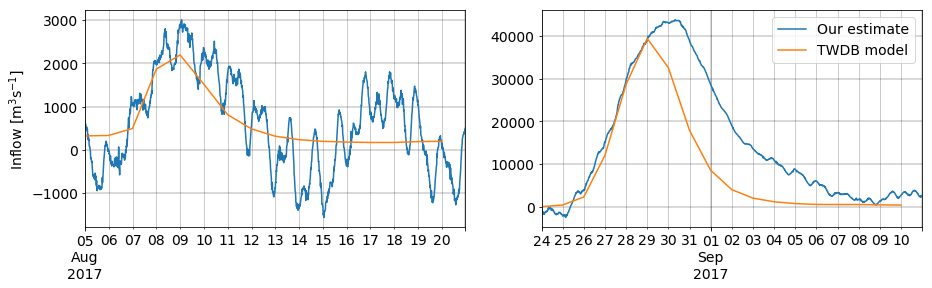

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

(Qin.rolling(window=4*24*3, min_periods=1, center=True).mean())['2017-8-5':'2017-8-20'].plot(grid=True, ax=axes[0])
inf['2017-8-5':'2017-8-20'].plot(ax=axes[0])

(Qin['2017-8-24':'2017-9-10'].rolling(window=4*24*3, min_periods=1, center=True).mean()).plot(grid=True, ax=axes[1])
inf['2017-8-24':'2017-9-10'].plot(ax=axes[1])

for ax in axes:
    ax.grid(which='major', lw=1.5, color='k', alpha=0.2)
    ax.grid(which='minor', lw=1, color='k', alpha=0.2)
axes[0].set_ylabel('Inflow [m$^3$s$^{-1}$]')
axes[1].legend(['Our estimate', 'TWDB model'])

fig.savefig('figures/inflow_comp.pdf', bbox_inches='tight')

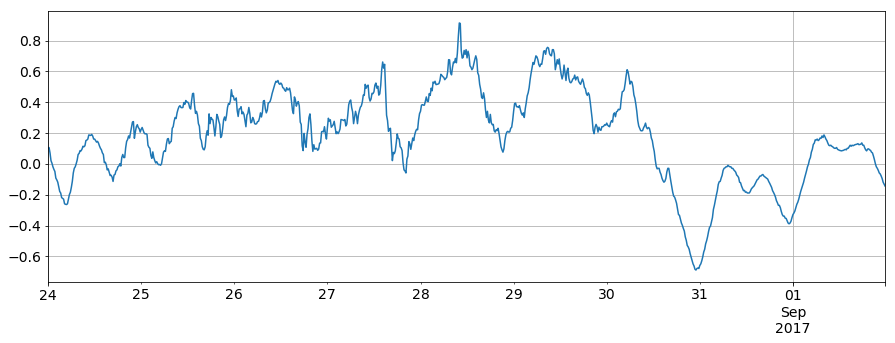

In [44]:
df['8770822: Water Level [m]']['2017-8-24':'2017-9-1'].plot(figsize=(15,5), grid=True)

# Numbers and comparison

Use cumulative sums to examine inflow since signal is wiggly. Plot shows what we use as the start and stop of the inflow. These dates were chosen by looking at the previous plot.

In [45]:
Vincum = Qin['2017-8-1':].cumsum()*dt  # multiply by time for integration, m^3

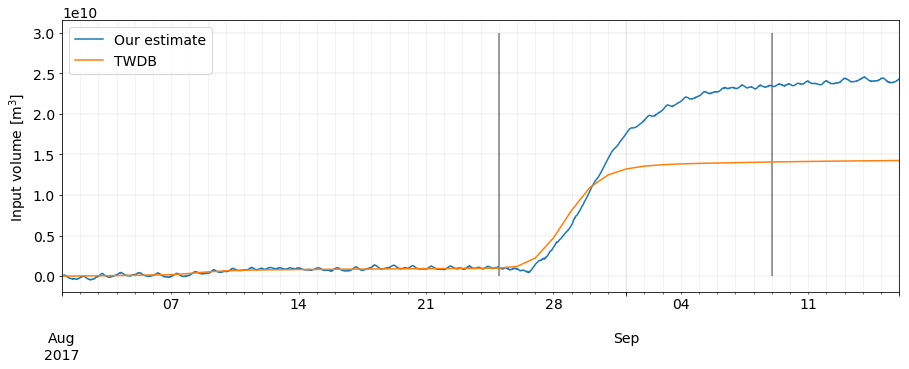

In [46]:
dst4 = '2017-8-1'; den4 =  '2017-9-15'
ax = Vincum[dst4:den4].plot(figsize=(15,5), grid=True)
# Vincum2[dst4:den4].plot(figsize=(15,5), grid=True)
ax.set_ylabel('Input volume [m$^3$]')
(inf*86400).cumsum().plot()


# dpre = '2017-8-1'  # start of pre-storm
dstorm = '2017-8-25 00:00'  # start of storm
dpost = '2017-9-9  00:00' # '2017-9-5 00:00'  # post storm
ax.vlines(dstorm, 0,3e10, alpha=0.5)
ax.vlines(dpost, 0,3e10, alpha=0.5)

ax.grid(which='major', lw=1.5, color='k', alpha=0.05)
ax.grid(which='minor', lw=1, color='k', alpha=0.05)

ax.legend(['Our estimate', 'TWDB'], loc='upper left')

plt.savefig('figures/inflow_cum.pdf', bbox_inches='tight')


## Inflow before storm (check)

Add up in flow before storm and compare with TWDB watershed calculation.

### Our estimate

In [47]:
# dstart = '2017-8-1'

print('August 1 through August 23:')
print('Volume inflow: %2.1f km^3' % (Qin['2017-8-1':'2017-8-23 23:45'].sum()*dt/1000**3))
print('Mean flow rate: %3.0f m^3/s' % (Qin['2017-8-1':'2017-8-23 23:45'].mean()))

August 1 through August 23:
Volume inflow: 1.0 km^3
Mean flow rate: 508 m^3/s


### Salinity conservation estimate (method 1b, which applies before the storm)

In [48]:
# calculate inflow using salinity conservation (only to be used before or after flooding)
Qin1b = Qch1b + dVdt + dVwdt

print('August 1 through August 23:')
print('Volume inflow: %2.1f km^3' % (Qin1b['2017-8-1':'2017-8-23 23:45'].sum()*dt/1000**3))
print('Mean flow rate: %3.0f m^3/s' % (Qin1b['2017-8-1':'2017-8-23 23:45'].mean()))

August 1 through August 23:
Volume inflow: 0.8 km^3
Mean flow rate: 403 m^3/s


### TWDB estimate

In [49]:
print('August 1 through August 23:')

# multiply by seconds per day to get volume
VTWDB = (inf['2017-8-1':'2017-8-23']*86400).sum()/1000**3
print('Volume inflow: %2.2f km^3' % VTWDB)
print('Mean flow rate: %3.0f m^3/s' % (inf['2017-8-1':'2017-8-23 23:45'].mean()))

August 1 through August 23:
Volume inflow: 0.96 km^3
Mean flow rate: 482 m^3/s


## Inflow during storm (main result)

### Ours:

In [50]:
print('%s through %s:' % (dstorm, dpost))
print('Volume inflow: %2.1f km^3' % (Qin[dstorm:dpost].sum()*dt/1000**3))
print('Mean flow rate: %3.0f m^3/s' % (Qin[dstorm:dpost].mean()))

2017-8-25 00:00 through 2017-9-9  00:00:
Volume inflow: 22.4 km^3
Mean flow rate: 17259 m^3/s


### TWDB

In [51]:
print('%s through %s:' % (dstorm, dpost))
VTWDB = (inf[dstorm:dpost]*86400).sum()/1000**3
print('Volume inflow: %2.1f km^3' % VTWDB)
print('Mean flow rate: %3.0f m^3/s' % (inf[dstorm:dpost].mean()))

2017-8-25 00:00 through 2017-9-9  00:00:
Volume inflow: 13.1 km^3
Mean flow rate: 9486 m^3/s


## Histograms of results for different dates for scaling channel velocity



In [67]:
def run_calculation(startdate, enddate):
    '''Run all of previous calculation in one function to compare numbers quickly.'''
    
    dst1 = startdate; det1 = enddate

    # try splitting into ebb and flood for fit
    ind = (~Uch[dst1:det1].isnull()) & (~Qch1b[dst1:det1].isnull()).values
    indf = ind[Uch[dst1:det1] < 0]  # into the bay, flood tide, since switched sign already
    inde = ind[Uch[dst1:det1] >= 0]  # out of the bay, ebb tide
    Uf = Uch[dst1:det1][Uch[dst1:det1] < 0].copy()
    Qf = Qch1b[dst1:det1][Uch[dst1:det1] < 0].rolling(window=8, center=True).mean().copy()
    Ue = Uch[dst1:det1][Uch[dst1:det1] >= 0].copy()
    Qe = Qch1b[dst1:det1][Uch[dst1:det1] >= 0].rolling(window=8, center=True).mean().copy()

    # only use non-nans between the two time series
    locs = ~Uf.isnull() & ~Qf.isnull() & (Sch[dst1:det1][Uch[dst1:det1] < 0] > 5)
    fitf = curve_fit(fixed_line, Uf[locs], Qf[locs])
    data_fit = fixed_line(Uf, *fitf[0])

    locs = ~Ue.isnull() & ~Qe.isnull() & (Sch[dst1:det1][Uch[dst1:det1] >= 0] > 5)
    fite = curve_fit(fixed_line, Ue[locs], Qe[locs])
    data_fit = fixed_line(Ue, *fite[0])

    Qcht = Uch.copy()
    Qcht[Uch < 0] = Uch[Uch < 0]*fitf[0]
    Qcht[Uch >= 0] = Uch[Uch >= 0]*fite[0]

    # this is now the improved flux calculation which applies during the storm too

    Qch = Qcht.copy()

    
    # sea level at buoy 8771013 for main bay
    detadt = eta.diff()/dt
    dVdt = Am * detadt

    # sea level at buoy 8771486 for west bay
    detawdt = etaw.diff()/dt
    dVwdt = Aw * detawdt
    
    
    Qin = Qch + dVdt + dVwdt

    
    preV = Qin['2017-8-1':'2017-8-23 23:45'].sum()*dt/1000**3
    stormV = Qin[dstorm:dpost].sum()*dt/1000**3

    return preV, stormV

In [69]:
startdates = [pd.Timestamp('2017-7-1')+pd.Timedelta(str(i) + ' days') for i in range(51)]
enddate = '2017-8-24'

preV = np.zeros(len(startdates)); stormV = np.zeros(len(startdates))
for i, startdate in enumerate(startdates):
    preV[i], stormV[i] = run_calculation(startdate, enddate)

Text(0.5,0,'Storm inflow [km$^3$]')

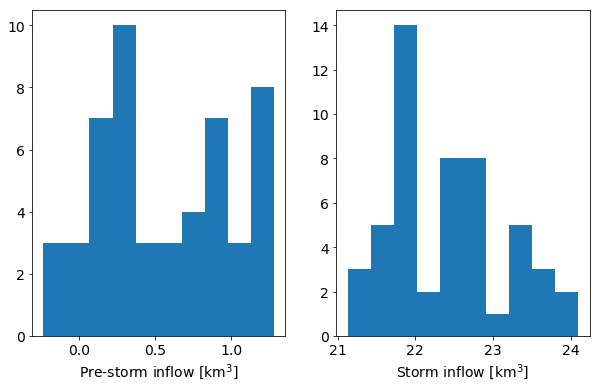

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))
# pre-storm
axes[0].hist(preV)
axes[0].set_xlabel('Pre-storm inflow [km$^3$]')
# during storm
axes[1].hist(stormV)
axes[1].set_xlabel('Storm inflow [km$^3$]')


## Compare with volume of Galveston Bay

Average volume of Galveston Bay:

In [52]:
# Galveston Bay volume with west bay too
Vfull = (Afull*Hfull)/1000**3  # km^3
print('Average volume of Galveston Bay: %2.2f km^3:' % Vfull)

Average volume of Galveston Bay: 2.62 km^3:


This means that the flood water could fill the bay approximately:

In [53]:
print(Vin/Vfull)

NameError: name 'Vin' is not defined

times.

## Compare with the precipitation estimates over Texas

In [86]:
precipgals = 20e12  # gallons rain from Harvey, NOAA estimate found on presentation (reference in paper)
precip = precipgals*0.00378541  # m^3, 1 gallon = 0.00378541 m^3
precip /= 1000**3
precip  # km^3

75.7082

ratio of rain that ended up in Galveston Bay

In [87]:
print(Vin/precip)

0.295299859689


or about 1/3 of the rainfall.

## Compare with peak discharge from Mississippi

There were 3 flood events since 2004 in this record with flow rate values over 35,000 m^3. The peak was in 2011, shown below. This is referenced in the paper to compare peak flow rates.

In [88]:
# read in data for Mississippi river gauge at Baton Rouge, station 07374000
import tabs
miss = tabs.read('07374000', '2004-3-17','2018-1-1')

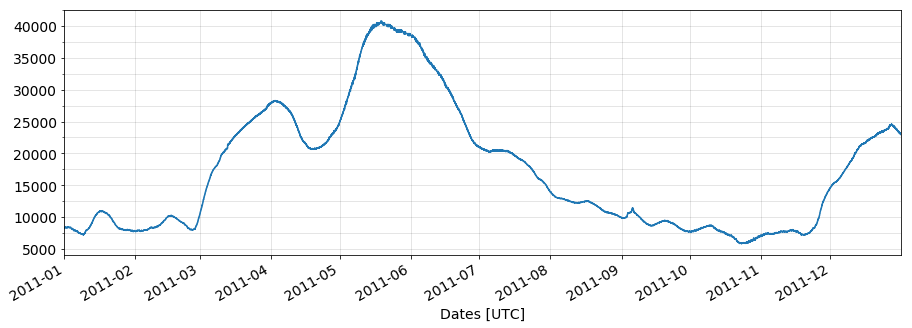

In [89]:
ax = miss['2011'].plot(legend=False, figsize=(15,5))

from matplotlib.ticker import AutoMinorLocator
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
ax.yaxis.set_minor_locator(minor_locator)
ax.grid(which='minor')

ax.grid(which='major', lw=1, color='k', alpha=0.1)
ax.grid(which='minor', lw=1, color='k', alpha=0.1)


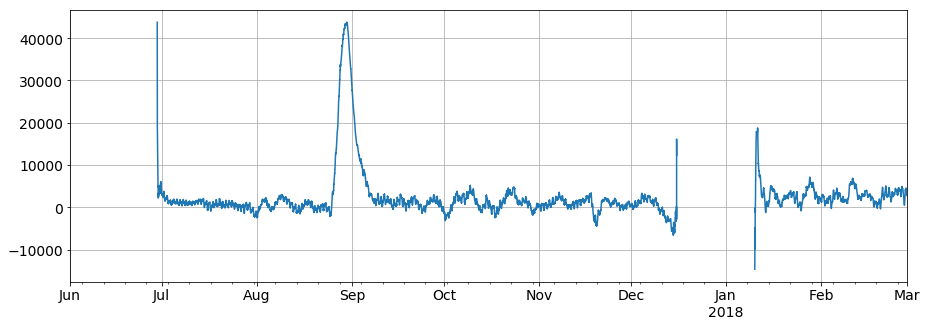

In [92]:
(Qin.rolling(window=4*24*3, min_periods=1, center=True).mean()).plot(figsize=(15,5), grid=True)